# COMP-767: Reinforcement Learning - Assignment 2

## 1. Prediction and control in RL [50 points] 

In this task, you will compare the performance of SARSA, expected SARSA and Q-learningon the Taxi domain from the Gym environment suite:https://gym.openai.com/envs/Taxi-v2/ 
 
 Use a tabular representation of the state space, and ensure that the starting and end location of the passenger are random. Exploration should be softmax (Boltzmann).  You will need to run the following protocol.  You will do 10 independent runs.  Each run consists of 100 segments, in each segment there are 10 episodes of training, followed by 1 episode in which you simply run the optimal policy so far (i.e. you pick actions greedily based on the current value estimates). Pick 3 settings of the temperature parameter used in the exploration and 3 settings of the learning rate. 
 
 You need to plot:
 
* One u-shaped graph that shows the effect of the parameters on the final training performance, expressed as the return of the agent (averaged over the last 10 training episodes and the 10 runs); note that this will typically end up as an upside-down u.
 
* One u-shaped graph that shows the effect of the parameters on the final testing performance, expressed as the return of the agent (during the final testing episode, averaged over the 10 runs)
 
* Learning curves (mean and standard deviation computed based on the 10 runs) for what you pick as the best parameter setting for each algorithm

Write a small report that describes your experiment,  your choices of parameters,  and the conclusions you draw from the graphs.

In [1]:
%load_ext autoreload
%autoreload 2

import gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
from multiprocessing import Pool

import temporal_difference
import function_approximation

In [2]:
def get_q(env):
    num_actions = 6
    num_states = 5*5*5*4
    q = {state: np.random.rand(num_actions) for state in range(num_states)}

    for loc_id in range(len(env.locs)):
        loc = env.locs[loc_id]
        s = env.encode(loc[0], loc[1], loc_id, loc_id)
        q[s] = np.zeros(num_actions)
    
    return q

In [3]:
def test_optimal_policy(q, env, discount_rate=0.9, show=True):
    policy_greedy = temporal_difference.Greedy(n=6)
    s = env.reset()
    a = policy_greedy.get_action(q, s)
    history = temporal_difference.History(s, a, discount_rate)
    done = False
    
    if show : 
        env.render()
        
    while not done:
        observation, reward, done, info = env.step(a)
        s = observation
        a = policy_greedy.get_action(q, s)
        history.register(s, a, reward)
        if show : 
            env.render()
            print(f"Timestep: {history.t}, Reward: {reward}, Total reward: {history.undiscounted_return()}, Discounted reward: {history.discounted_return()}")
    return history

In [4]:
def run(update_algorithm, 
        temperature_factor=1, 
        learning_rate=0.5, 
        n_segment=100, 
        episode_by_segment=10, 
        discount_rate = 0.9, 
        show=False, 
        print_segment=False):
    
    exploration_policy = temporal_difference.SoftmaxExploration(temperature_factor=temperature_factor)
    env = gym.make('Taxi-v2')
    q = get_q(env.unwrapped)
    
    training_results=[]
    testing_results = []
    for segment in range(n_segment):
        for episode in range(episode_by_segment):
            episode_history = update_algorithm(env, exploration_policy, q, learning_rate, discount_rate)
            training_results.append(episode_history.undiscounted_return())
        
        testing_history = test_optimal_policy(q, env, discount_rate, show)
        testing_results.append(testing_history.undiscounted_return())
        
        if print_segment:
            print("Segment : %2i, Timestep : %3i, Total reward : %5i" % (segment, 
                                                                         testing_history.t, 
                                                                         testing_history.undiscounted_return()))
    return training_results, testing_results


training_results, testing_results = run(temporal_difference.qlearning_update, print_segment=True, n_segment=10)

Segment :  0, Timestep : 200, Total reward : -1973
Segment :  1, Timestep : 200, Total reward :  -200
Segment :  2, Timestep : 200, Total reward :  -200
Segment :  3, Timestep : 200, Total reward :  -200
Segment :  4, Timestep : 200, Total reward :  -200
Segment :  5, Timestep : 200, Total reward :  -200
Segment :  6, Timestep : 200, Total reward :  -200
Segment :  7, Timestep : 200, Total reward :  -200
Segment :  8, Timestep : 200, Total reward :  -200
Segment :  9, Timestep : 200, Total reward :  -200


In [5]:
def subplot(name, algo, results, learning_rates, temperature_factors):
    for i in range(len(results)):
        plt.plot(learning_rates, results[i,:], label=temperature_factors[i])
    plt.legend()
    plt.title(algo + " during " + name)
    plt.xlabel("learning rate")
    plt.ylabel("Cumulative reward")
    
def plot_parameter_effect(algo, train, test, learning_rates, temperature_factors):
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    subplot("training", algo, train, learning_rates, temperature_factors)

    plt.subplot(1, 2, 2)
    subplot("testing", algo, test, learning_rates, temperature_factors)
    plt.show()

SARSA


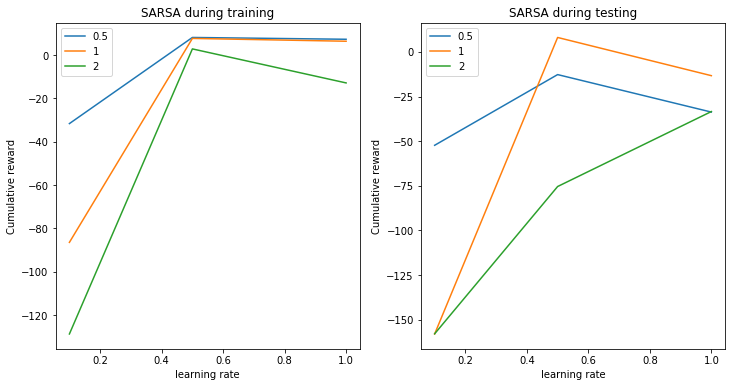

Best return : 8.1, learning rate = 0.5, and temperature factor = 1 



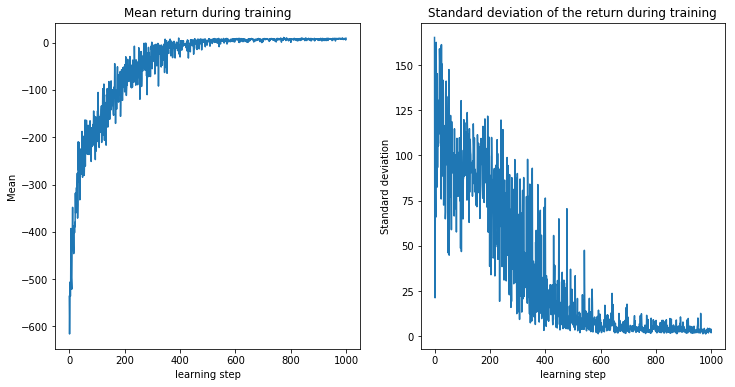

Expected SARSA


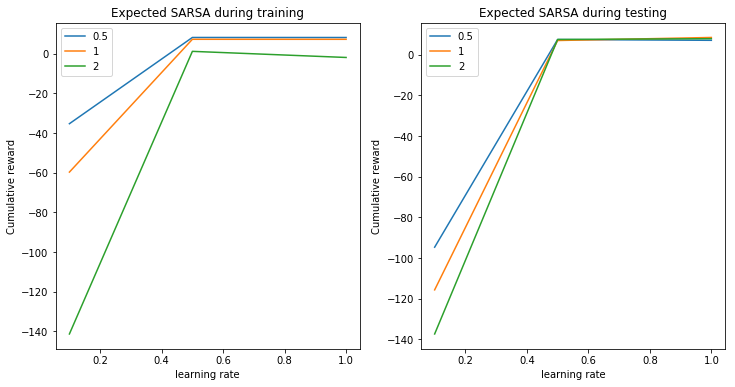

Best return : 8.5, learning rate = 1, and temperature factor = 1 



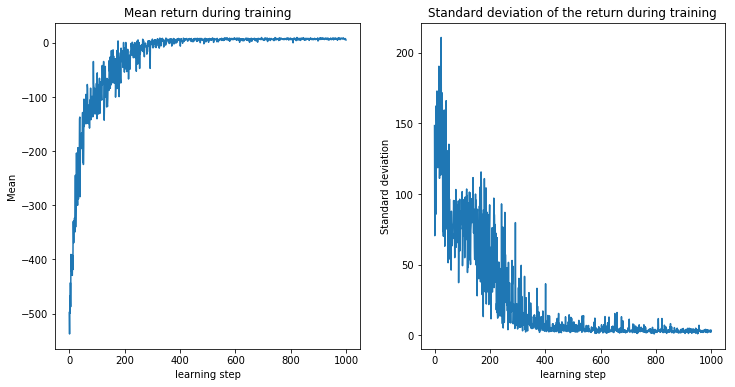

Q-learning


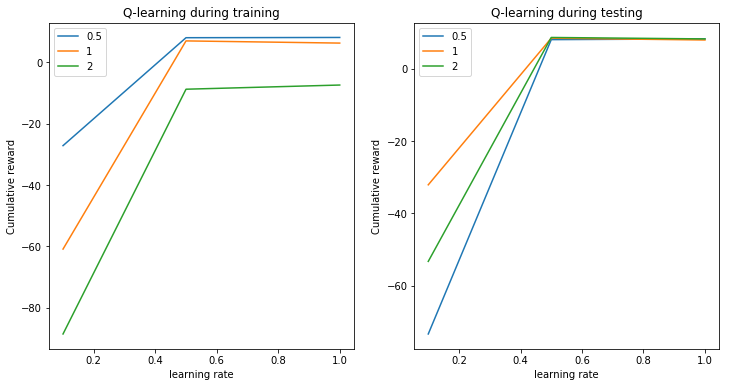

Best return : 8.7, learning rate = 0.5, and temperature factor = 2 



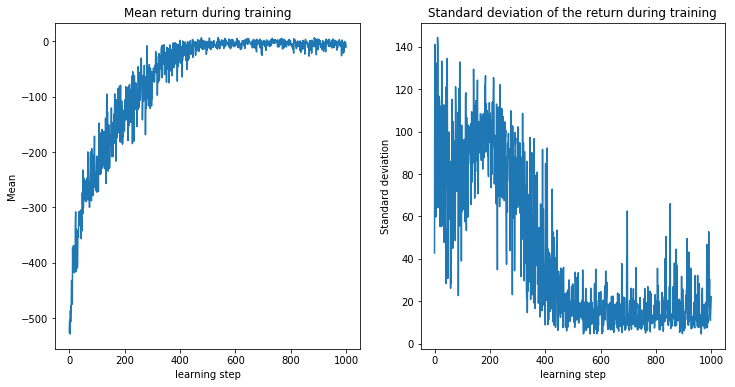

In [6]:
def experiment(update_algorithm, temparature_factor, learning_rate):
    n_run = 10
    n_segment=100
    episode_by_segment=10
    
    train = np.zeros((n_run, n_segment*episode_by_segment))
    test = np.zeros((n_run,n_segment))
    for i in range(n_run):
        train[i,:], test[i,:] = run(update_algorithm, temparature_factor, learning_rate, n_segment, episode_by_segment)
    
    return train, test

def final_training_performance(train):
    return np.mean(train[:,-10:])

def final_testing_performance(test):
    return np.mean(test[:,-1:])

def filter_results(r):
    train, test = [], []
    for train_, test_ in r:
        train.append(final_training_performance(train_))
        test.append(final_testing_performance(test_))
    
    train = np.array(train).reshape(3,3)
    test = np.array(test).reshape(3,3)
    
    return train, test

def get_best(test, learning_rates, temperature_factors):
    argmax = test.argmax()
    tf_index, lr_index = np.unravel_index(argmax, test.shape)
    return test[tf_index, lr_index], learning_rates[lr_index], temperature_factors[tf_index], argmax

def get_learning_curve(r, amax, train=True):
    data = r[amax][0] if train else r[amax][1]
    return np.mean(data, axis=0), np.std(data, axis=0)

def plot_learning_curve(r, amax):
    mean, std = get_learning_curve(r, amax, train=True)
    
    fig = plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(mean)
    plt.title("Mean return during training")
    plt.xlabel("learning step")
    plt.ylabel("Mean")

    plt.subplot(1, 2, 2)
    plt.plot(std)
    plt.title("Standard deviation of the return during training")
    plt.xlabel("learning step")
    plt.ylabel("Standard deviation")
    
    plt.show()

def algorithm_parameters_effect_parallel(update_algorithm, learning_rates, temperature_factors):
    print(update_algorithm)
    sys.stdout.flush()
    p = Pool(10)

    settings=[]
    for temparature_factor in temperature_factors:
        for learning_rate in learning_rates:
            settings.append((algorithms[update_algorithm], temparature_factor, learning_rate))
    r = p.starmap(experiment, settings)
    
    train, test = filter_results(r)


    plot_parameter_effect(update_algorithm, train, test, learning_rates, temperature_factors)
    max_return, lr, tf, amax = get_best(test, learning_rates, temperature_factors)
    print(f"Best return : {max_return}, learning rate = {lr}, and temperature factor = {tf} \n")
    
    plot_learning_curve(r, amax)

algorithms = {"SARSA":temporal_difference.sarsa_update, 
              "Expected SARSA": temporal_difference.expected_sarsa_update, 
              "Q-learning":temporal_difference.qlearning_update}
temperature_factors= [0.5, 1, 2]
learning_rates = [0.1, 0.5, 1]

for algo in algorithms:
    algorithm_parameters_effect_parallel(algo, learning_rates, temperature_factors)

WRITE SOME TEXT to explain the graphs

# 2. Function approximation [50 points]
Implement and compare empirically Monte Carlo and TD-learning with eligibility traces and linear function approximation on the Pendulum-v0 domain from the Gym environment suite:https://gym.openai.com/envs/Pendulum-v0/ 

You should evaluate the fixed policy that produces torque in the same direction as the current velocity with probability 0.9 and in the opposite direction with probability 0.1. If velocity is 0, you can torque in a random direction. 

For this experiment, you should use a tile coding function  approximator, in which you discretize  the  angular  position  and angular velocity into 10 bins each, and use 5 overlapping tilings, whose weights start initialized randomly between −0.001 and 0.001. 

You will need to use the same seed for this initialization for all parameters settings, but will have 10 different seeds (for the different runs). You should use values of λ={0, 0.3, 0.7, 0.9, 1}. For each value, use 3 settings of the learning rate parameter α = {1/4, 1/8, 1/16}. Remember that the learning rate per parameter needs to be divided by the number of overlapping tilings. 

Perform 10 independent runs, each of 200 episodes. Each episode should start art state (0,0).  Plot 5 graphs, one for each of the λ-values, showing the value of the start state, using each of the α-values (each of the 5 graphs has 3 curves). Explain briefly what you can conclude from these graphs, in terms of the speed of convergence and stability of these algorithms.

In [8]:
def policy(env, state, action_amplitude = None):
    probability_torque_same_direction = 0.9
    velocity = state[1]
    
    if action_amplitude == None or action_amplitude > env.unwrapped.max_torque:
        action_amplitude = env.unwrapped.max_torque
        
    action = np.array([action_amplitude * np.sign(velocity)])
    
    p = np.random.rand(1)
    if p > probability_torque_same_direction:
        action *= -1
    return action

def get_angle_velocity(observation):
    angle = np.arccos(observation[0])
    if observation[1] < 0:
        angle = 2 * np.pi - angle
    velocity = observation[2]
    return angle, velocity

def get_weights(size, weights_max_initial_range = 0.001, seed = None):
    np.random.seed(seed)
    return np.random.rand(size) * weights_max_initial_range * 2 - weights_max_initial_range

In [9]:
def reset_env(env):
    env.unwrapped.state = np.array([0,0])
    env.unwrapped.last_u = None
    return env.unwrapped._get_obs()

def q2_run(lambda_return, learning_rate, n_episode_by_run, n_bins, n_tilings, prediction_algorithm):

    env = gym.make('Pendulum-v0')
    env.reset()
    discount_rate=0.9
    low = np.array([0.0, -env.unwrapped.max_speed])
    high = np.array([2*np.pi, env.unwrapped.max_speed])
    state_observation_space = gym.spaces.Box(low=low, high=high, dtype=np.float32)
    approximation_function = function_approximation.TileCoding2D(n_bins=n_bins, 
                                                             n_tilings=n_tilings,
                                                             bounds_box = state_observation_space)
    weights = get_weights(approximation_function.size)
    
    state_to_estimate = np.array([0,0])
    approximate_value = [approximation_function(state_to_estimate, weights)]
    for episode in range(n_episode_by_run):
        weights = prediction_algorithm(env, policy, 
                                        learning_rate=learning_rate/n_tilings, 
                                        discount_rate=discount_rate,
                                        lambda_return=lambda_return, 
                                        approximation_function=approximation_function, 
                                        weights = weights, 
                                        state_from_observation_function= get_angle_velocity, 
                                        reset_function = reset_env)
        approximate_value.append(approximation_function(state_to_estimate, weights))
        
    return approximate_value
q2_run(lambda_return=0.5, learning_rate=0.9, 
       n_episode_by_run=10, n_bins=10, n_tilings=5, 
       prediction_algorithm = temporal_difference.semi_gradient_td_update)

[0.0015718444059254558,
 -0.00749520242759091,
 -0.5236852880649709,
 -0.575304296628709,
 -0.5804661974850829,
 -0.5809823875707201,
 -0.5810340065792841,
 -0.5810391684801403,
 -0.5810396846702259,
 -0.5810397362892346,
 -0.5810397414511353]

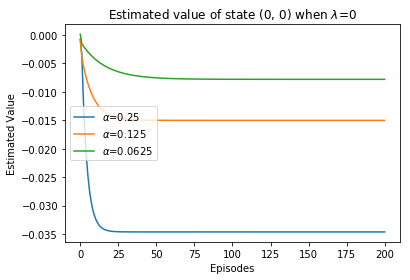

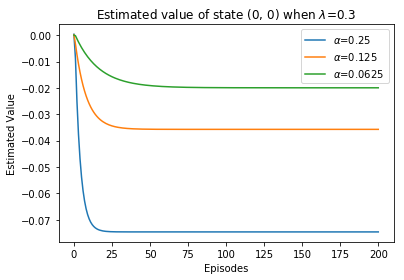

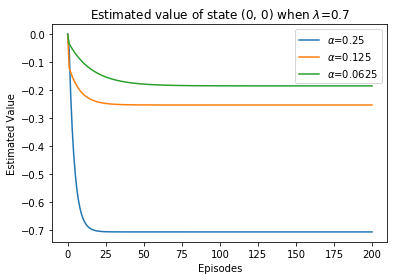

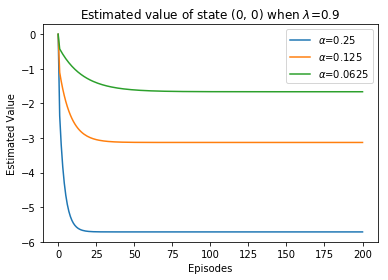

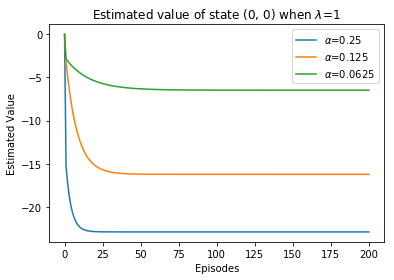

In [10]:
def get_lambda_plot(lambda_return, learning_rates, n_run = 10,
       n_episode_by_run=10, n_bins=10, n_tilings=5, 
       prediction_algorithm = temporal_difference.semi_gradient_td_update):
    
    for learning_rate in learning_rates:
        runs = np.zeros((n_run, n_episode_by_run+1))
        for run in range(n_run):
            runs[run,:] = q2_run(lambda_return, learning_rate, n_episode_by_run, n_bins, n_tilings, prediction_algorithm)
        plt.plot(np.mean(runs, axis=0), label=r"$\alpha$"+f"={learning_rate}")
    plt.title(f"Estimated value of state {(0,0)} when $\lambda$={lambda_return}")
    plt.xlabel("Episodes")
    plt.ylabel("Estimated Value")
    plt.legend()

    
lambda_returns = [0, 0.3, 0.7, 0.9, 1]
learning_rates = [1/4, 1/8, 1/16]
n_run = 10
n_episode_by_run = 200
n_bins = 10
n_tilings = 5

for lambda_return in lambda_returns:
    get_lambda_plot(lambda_return, learning_rates, n_run, n_episode_by_run, n_bins, n_tilings, 
                    temporal_difference.semi_gradient_td_update)
    plt.show()